<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 26.63 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c6b2690d8d0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

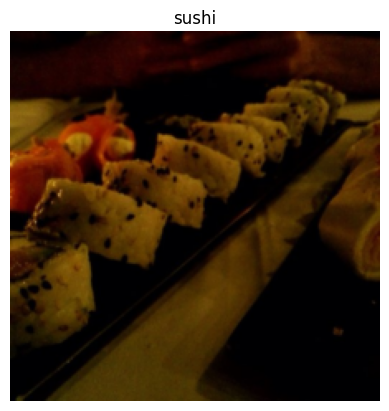

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

EffNetB2

Creating an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"
  # 2. Get EffNetB2 transforms
  transforms = weights.transforms()
  # 3. Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights) # could also use weights="DEFAULT"
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True))
  return model, transforms

In [ ]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                            seed=42)

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Creating DataLoaders for EffNetB2

In [ ]:
#create dataloader
from going_modular.going_modular import data_setup
train_dataloader_effentb2,test_dataloader_effentb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                 test_dir=test_dir,
                                                 transform=effnetb2_transforms,
                                                 batch_size=32)

In [ ]:
len(train_dataloader_effentb2),len(test_dataloader_effentb2),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine
#loss function
loss_fn = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.Adam(params=effnetb2_model.parameters(),
                             lr=1e-3)
#training

set_seeds()
effnetb2_model_results = engine.train(model=effnetb2_model,
                                       train_dataloader=train_dataloader_effentb2,
                                       test_dataloader=test_dataloader_effentb2,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       epochs=10,
                                       device="cuda")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


Inspecting EffNetB2 loss curves

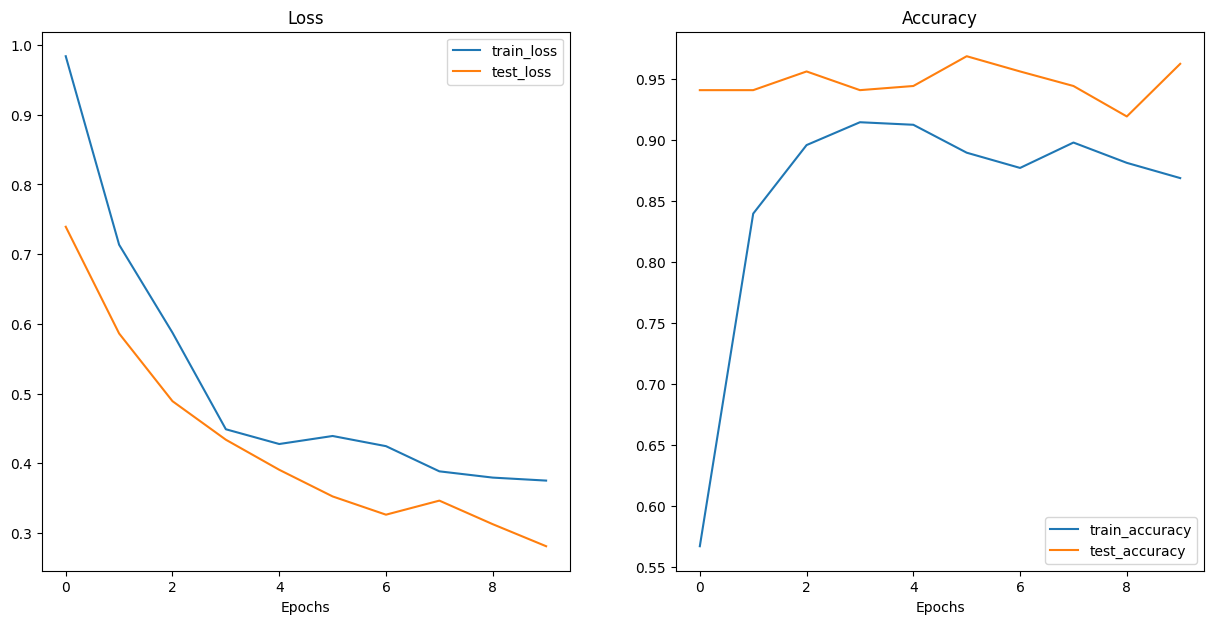

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_model_results)

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2_model,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path
# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_model_results["test_loss"][-1],
                  "test_acc": effnetb2_model_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

Creating an viT feature extractor

In [ ]:
def create_vit_model(num_classes:int=3,
              seed:int=42):
  # 1. Get pretrained weights for ViT-Base
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available
  transforms = weights.transforms()
  # 2. Setup a ViT model instance with pretrained weights
  model = torchvision.models.vit_b_16(weights=weights).to(device)

  # 3. Freeze the base parameters
  for parameter in model.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
  # pretrained_vit # uncomment for model output
  return model, transforms

In [ ]:
vit_model, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.1MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup vit dataloaders
from going_modular.going_modular import data_setup
train_dataloader_vit_pretrained, test_dataloader_vit_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
len(train_dataloader_vit_pretrained),len(test_dataloader_vit_pretrained),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=vit_model,
                                      train_dataloader=train_dataloader_vit_pretrained,
                                      test_dataloader=test_dataloader_vit_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device="cuda")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


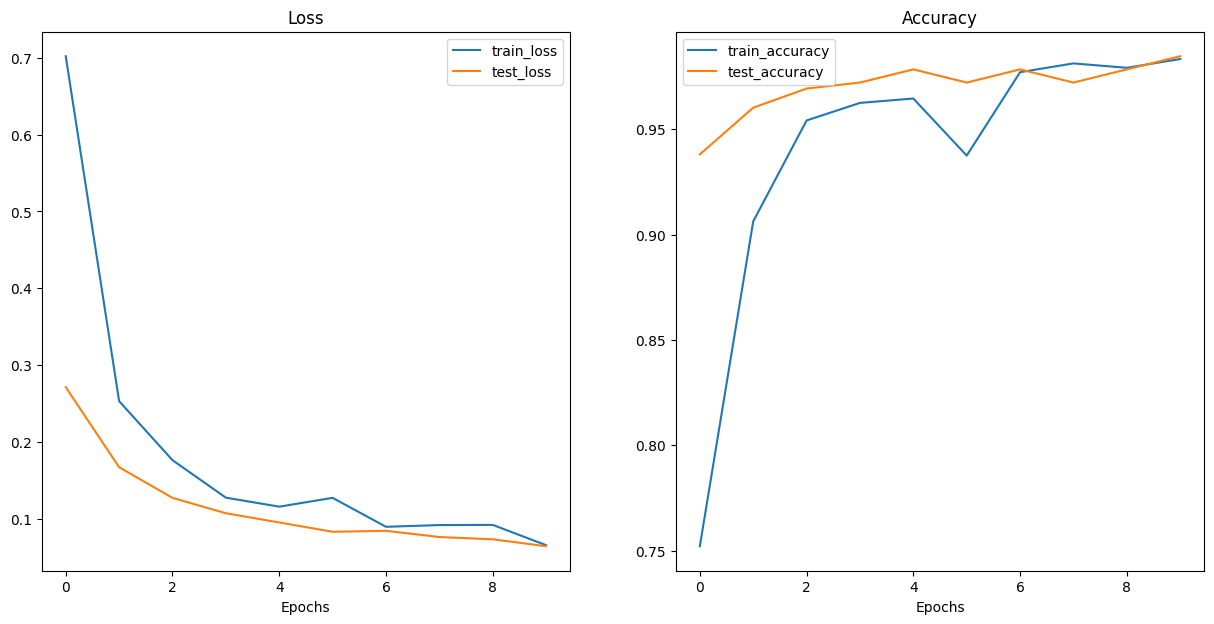

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

Saving ViT feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit_model,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path
# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size: {round(pretrained_vit_model_size, 2)} MB")

Pretrained vit feature extractor model size: 327.37 MB


In [ ]:
# Count number of parameters in vit
vit_total_params = sum(torch.numel(param) for param in vit_model.parameters())
vit_total_params

85800963

In [ ]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_loss": pretrained_vit_results["test_loss"][-1],
                  "test_acc": pretrained_vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3709087371826}

Making predictions with our trained models and timing them

In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2782998.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/204151.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/476421.jpg')]

In [ ]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict
import torchvision.transforms as transforms

# 1. สร้างฟังก์ชันที่รับรายการ paths, โมเดล PyTorch ที่ผ่านการฝึก, ชุด transforms, รายการชื่อคลาสเป้าหมาย และ target device
def pred_and_store(model: torch.nn.Module,
                  target_paths: List[pathlib.Path],
                  transforms: transforms.Compose,
                  class_names: List[str],
                  device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. สร้างลิสต์ว่าง (เพื่อเก็บผลการทำนายทั้งหมด)
  pred_list = []
  # 3. วนลูปในรายการ paths ที่ต้องการประมวลผล
  for path in tqdm(target_paths):
    # 4. สร้างดิกชันนารีว่างสำหรับแต่ละตัวอย่าง (เพื่อเก็บข้อมูลการทำนาย)
    pred_dict = {}
    # 5. ดึง path และ ground truth class (ground truth = "คำเฉลยคำตอบ") จาก filepath
    pred_dict["image_path"] = path
    pred_dict["ground_truth_class"] = path.parent.stem # `parent` ใช้สำหรับดึงชื่อโฟลเดอร์
    # 6.
    start_time = timer()
    # 7. เปิดภาพโดยใช้ `PIL.Image.open(path)`
    img = Image.open(path)
    # 8. ทำการแปลงภาพให้เหมาะสมกับโมเดล
    transformed_image = transforms(img).unsqueeze(0).to(device)
    # 9. ย้ายโมเดลไปที่ device ก่อนเริ่มลูป
    model = model.to(device)
    model.eval()
    # 10. ใช้ `torch.inference_mode()` และส่งภาพที่แปลงแล้วเข้าสู่โมเดลเพื่อคำนวณผลลัพธ์ + ความน่าจะเป็น (pred prob) + คลาสที่ทำนาย (pred class)
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # แปลงค่า logits ให้เป็นค่าความน่าจะเป็นของการทำนาย
      pred_label = torch.argmax(pred_prob, dim=1)  # แปลงค่าความน่าจะเป็นของการทำนายให้เป็นป้ายกำกับการทำนาย
      pred_class = class_names[pred_label.cpu()] # การกำหนดคลาสการทำนายให้ทำงานบน CPU (ตัวแปรใน Python จะถูกจัดเก็บอยู่บน CPU)
    # 11. เพิ่มข้อมูลความน่าจะเป็น + คลาสที่ทำนายลงในดิกชันนารีที่สร้างไว้ในข้อ 5
    pred_dict["pred_prob"] = round(pred_prob.squeeze(0).max().cpu().item(), 4)
    pred_dict["pred_class"] = pred_class
    # 12. หยุดจับเวลาที่เริ่มในข้อ 6 และเพิ่มเวลาในดิกชันนารี
    end_timer = timer()
    pred_dict["prediction_time"] = round(end_timer - start_time, 4)
    # 13. ตรวจสอบว่าคลาสที่ทำนายตรงกับคลาสจริงหรือไม่
    pred_dict["correct"] = pred_dict["ground_truth_class"] == pred_class
    # 14. เพิ่มดิกชันนารีที่อัปเดตแล้วไปในลิสต์ผลการทำนายที่สร้างไว้ในข้อ 2
    pred_list.append(pred_dict)

  # 15. คืนค่าลิสต์ผลการทำนาย
  return pred_list


Make and time predictions on CPU

In [ ]:
#predict effenb2
effnetb2_test_pred_cpu  = pred_and_store(model = effnetb2_model,
                         target_paths = test_data_paths,
                         transforms = effnetb2_transforms,
                         class_names = class_names,
                         device = "cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_cpu[:1]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'ground_truth_class': 'pizza',
  'pred_prob': 0.9567,
  'pred_class': 'pizza',
  'prediction_time': 0.1374,
  'correct': True}]

In [ ]:
#predict viT
vit_test_pred_cpu  = pred_and_store(model = vit_model,
                         target_paths = test_data_paths,
                         transforms = vit_transforms,
                         class_names = class_names,
                         device = "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_cpu[:1]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'ground_truth_class': 'pizza',
  'pred_prob': 0.9959,
  'pred_class': 'pizza',
  'prediction_time': 0.5163,
  'correct': True}]

Comparing prediction times on CPU and GPU

In [ ]:
effnetb2_test_pred_GPU  = pred_and_store(model = effnetb2_model,
                         target_paths = test_data_paths,
                         transforms = effnetb2_transforms,
                         class_names = class_names,
                         device = "cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_GPU  = pred_and_store(model = vit_model,
                         target_paths = test_data_paths,
                         transforms = vit_transforms,
                         class_names = class_names,
                         device = "cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

Make and time predictions on GPU

In [ ]:
import pandas as pd

def get_mean_pred_time(input_data):
    """
    Calculate the mean prediction time from a list of dictionaries.

    Args:
        input_data (list): A list of dictionaries, each containing prediction details.

    Returns:
        float: The mean prediction time.
    """

    # Check if input_data is not empty
    if input_data:
        df = pd.DataFrame(input_data)

        # Assuming the prediction time is stored under the key 'prediction_time'
        # Adjust this key if it's different in your data.
        if 'prediction_time' in df.columns:
            return df['prediction_time'].mean()
        else:
            print("Warning: 'prediction_time' column not found in the data.")
            return None
    else:
        print("Warning: Input data is empty.")
        return None



In [ ]:
effnetb2_cpu_pred_time = get_mean_pred_time(effnetb2_test_pred_cpu)
print(effnetb2_cpu_pred_time)

0.10804399999999999


In [ ]:
effnetb2_gpu_pred_time = get_mean_pred_time(effnetb2_test_pred_cpu)
vit_cpu_pred_time = get_mean_pred_time(vit_test_pred_cpu)
vit_gpu_pred_time = get_mean_pred_time(vit_test_pred_GPU)

pred_times = {"effnetb2_cpu": effnetb2_cpu_pred_time,
              "vit_cpu": vit_cpu_pred_time,
              "effnetb2_gpu": effnetb2_gpu_pred_time,
              "vit_gpu": vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

,effnetb2_cpu,vit_cpu,effnetb2_gpu,vit_gpu
0,0.108044,0.421071,0.108044,0.021139


## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

### แบบฝึกหัดที่ 2:

เนื่องจาก **ViT feature extractor** ดูเหมือนจะมีความสามารถในการเรียนรู้ที่มากกว่า (เนื่องจากจำนวนพารามิเตอร์ที่มากกว่า) เมื่อเทียบกับ **EffNetB2**  

**คำถาม:**  
- ViT จะทำงานได้ดีเพียงใดเมื่อใช้ชุดข้อมูล **20% ของ Food101** ที่ใหญ่ขึ้น?  

**สิ่งที่ต้องทำ:**  
- ฝึก (train) **ViT feature extractor** บนชุดข้อมูล **20% Food101** เป็นเวลา **5 epochs**  
- ใช้กระบวนการเดียวกับที่ใช้ในการฝึก **EffNetB2** ใน **Section 10: Creating FoodVision Big**  

In [ ]:
def create_vit_model(num_classes:int=3,
              seed:int=42):
  # 1. Get pretrained weights for ViT-Base
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available
  transforms = weights.transforms()
  # 2. Setup a ViT model instance with pretrained weights
  model = torchvision.models.vit_b_16(weights=weights).to(device)

  # 3. Freeze the base parameters
  for parameter in model.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
  # pretrained_vit # uncomment for model output
  return model, transforms

In [ ]:
#Create Food101 model and transforms
from torch import nn
import torchvision
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 67.4MB/s]


In [ ]:
# from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
# summary(effnetb2_food101,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
# Add Data Augmentation
#create training data tranforms useing TrivialAugment
food_train_transforms = torchvision.transforms.Compose([
  torchvision.transforms.TrivialAugmentWide(),
  effnetb2_transforms
])
food_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
#get dataset food101
from torchvision import datasets
from pathlib import Path
# Setup data directory
data_dir = Path("data")

#get the training data (~750 img x 101 classes)
train_data = datasets.Food101(root=data_dir,
                               split="train",
                               transform=food_train_transforms, # apply data augmentation to training data
                               download=True)

#get the testing data (~250 x 101)
test_data = datasets.Food101(root=data_dir,
                              split="test",
                              transform=effnetb2_transforms, # ***don't perform data augmentation on the test data
                              download=True)


100%|██████████| 5.00G/5.00G [03:47<00:00, 22.0MB/s]


Extracting data/food-101.tar.gz to data


In [ ]:
#Get food101 classes names
food101_class_name = train_data.classes
#View 10th classes names
food101_class_name[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  #create split len based on original data len
  length_1 = int(split_size * len(dataset))
  length_2 = len(dataset) - length_1
  #print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")
  #create random split
  random_split_1, random_split_2 = random_split(dataset,
                                                  [length_1, length_2],
                                                  generator=torch.Generator().manual_seed(seed))
  return random_split_1, random_split_2

In [ ]:
# create training 20% split food 101
import torch
train_data_food101_20_percent , _ = split_dataset(dataset=train_data,
                                                          split_size=0.2,
                                                          seed=42)
# create testg 20% split food 101
test_data_food101_20_percent , _ = split_dataset(dataset=test_data,
                                                         split_size=0.2,
                                                         seed=42)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [ ]:
import os
os_cpu_count = os.cpu_count()
os_cpu_count

2

In [ ]:
# Create training and testing DataLoaders see command -> torch.utils.data.DataLoader -> https://pytorch.org/docs/stable/data.html
import torchvision
BATCH_SIZE = 32
NUM_WORKERS = os_cpu_count
# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [ ]:
#training food101 model
from going_modular.going_modular import engine
from torch import nn


#optimizer
optimizer = torch.optim.Adam(params=vit_food101_20_percent.parameters(),
                             lr=1e-3)

#loss function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
#training

# set_seeds()
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                                       train_dataloader=train_dataloader_food101_20_percent,
                                       test_dataloader=test_dataloader_food101_20_percent,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       epochs=5,
                                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0206 | train_acc: 0.4431 | test_loss: 2.6021 | test_acc: 0.5067
Epoch: 2 | train_loss: 2.7668 | train_acc: 0.4569 | test_loss: 2.4170 | test_acc: 0.5438
Epoch: 3 | train_loss: 2.6161 | train_acc: 0.4929 | test_loss: 2.3378 | test_acc: 0.5633
Epoch: 4 | train_loss: 2.5226 | train_acc: 0.5142 | test_loss: 2.2889 | test_acc: 0.5781
Epoch: 5 | train_loss: 2.4830 | train_acc: 0.5257 | test_loss: 2.2738 | test_acc: 0.5814


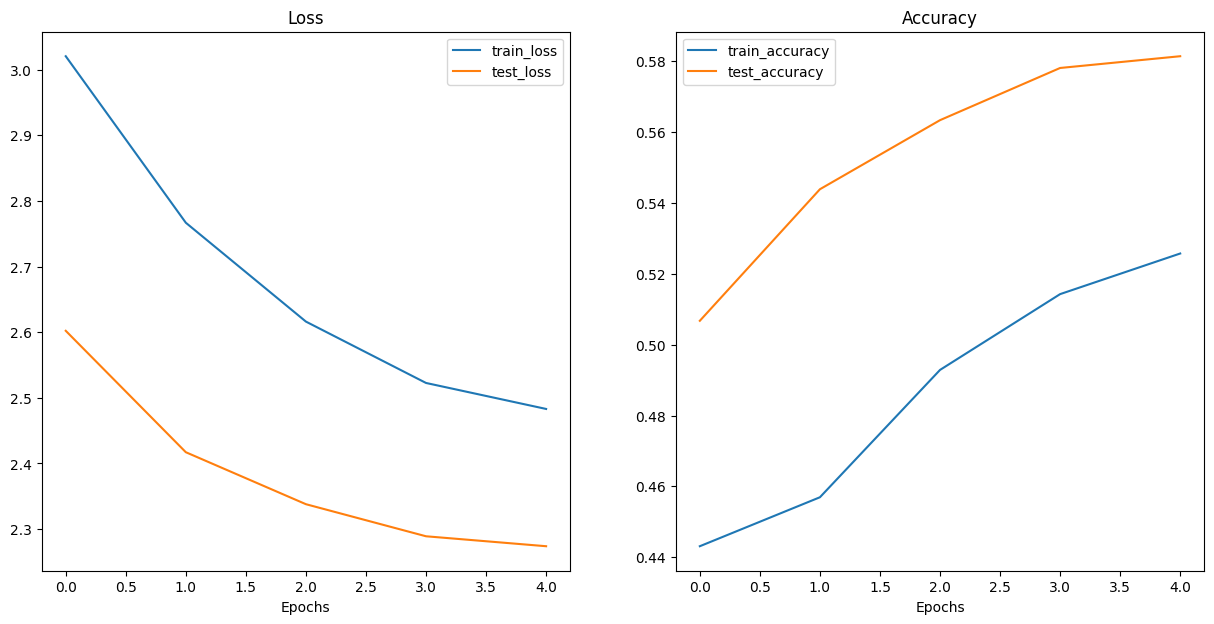

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_results)

In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2782998.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/204151.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/476421.jpg')]

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

แบบฝึกหัดที่ 3:
คำถาม:

* ทำนายผลบนชุดข้อมูล 20% Food101 test dataset โดยใช้ ViT feature extractor ที่ได้จากแบบฝึกหัดที่ 2
* ระบุ "most wrong" predictions (ผลทำนายที่ผิดพลาดที่สุด) ซึ่งเป็นผลทำนายที่มีความน่าจะเป็นสูงที่สุด (highest prediction probability) แต่ผลทำนายผิด

In [ ]:
vit_food101_20_percent = effnetb2_food101

In [ ]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [ ]:
food101_class_name[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create a column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_name[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_name[x])
pred_df_20_percent.head()

,pred_prob,pred_label,label,is_correct,pred_class,label_class
0,0.7713511,72,72,True,pancakes,pancakes
1,0.10620825,31,57,False,donuts,hummus
2,0.11489688,44,80,False,fried_rice,pulled_pork_sandwich
3,0.5744401,51,51,True,guacamole,guacamole
4,0.28836814,1,1,True,baby_back_ribs,baby_back_ribs


In [ ]:
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

,pred_prob,pred_label,label,is_correct,pred_class,label_class
2640,0.9080575,20,18,False,chicken_wings,chicken_curry
75,0.90196943,43,38,False,fried_calamari,fish_and_chips
1909,0.9017005,91,81,False,spaghetti_carbonara,ramen
3075,0.89597684,12,6,False,cannoli,beignets
3398,0.8835323,94,58,False,strawberry_shortcake,ice_cream
1807,0.87056303,55,53,False,hot_dog,hamburger
2859,0.8455446,74,20,False,peking_duck,chicken_wings
4611,0.8419289,91,90,False,spaghetti_carbonara,spaghetti_bolognese
3031,0.84058714,27,98,False,creme_brulee,tiramisu
2435,0.8381838,70,81,False,pad_thai,ramen


## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# Check length of Food101 test data
len(test_data)

25250

In [ ]:
# TODO: your code
# Create training and testing DataLoaders see command -> torch.utils.data.DataLoader -> https://pytorch.org/docs/stable/data.html
import torchvision
BATCH_SIZE = 1
NUM_WORKERS = os_cpu_count
# Create Food101 20% testing DataLoader
test_dataloader_food101_BATCH_SIZE_1 = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_BATCH_SIZE_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [ ]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

,count
is_correct,
True,2936
False,2114


In [ ]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

Accuracy of ViT model on all of Food101 test data: 0.4186138613861386


<ipython-input-90-c3917d7dadc8>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")


## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [ ]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [ ]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [ ]:
# TODO: your code